## MAP

Inspired by pair trading. For a thorough explanation refer to: https://github.com/quantopian/research_public/blob/master/notebooks/lectures/Introduction_to_Pairs_Trading/notebook.ipynb

The idea is to use 2 time series that should maintain some relationship over time. If this pair diverges from some expected relationship at any point in time then an exception is flagged.

In regards to MAP we compare each [site, article, uom] MAP against the overall [salesorgs, article, uom] MAP. Once the spread divergenes significantly from recent history an exception is flagged.

We also propose a dollar impact cut-off to avoid flagging too many immaterial divergences.

In [65]:
import warnings
warnings.filterwarnings('ignore')

In [66]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

# mount drive
from google.colab import drive
drive.mount('/content/drive')


Authenticated
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
!pip install dfply
from dfply import *

from google.cloud import bigquery
import pandas_gbq
import pandas as pd
import numpy as np
import sys
import os
import plotnine as p9
from mizani.formatters import currency_format
import matplotlib.pyplot as plt

# define functions

In [97]:
def run_bq(sql, client, location="US"):
    query_job = client.query(sql, location=location)
    # wait for query to run_bq
    query_job.result()

def get_bq_data(sql, project_id):
    import pandas_gbq
    return pandas_gbq.read_gbq(sql,
                               project_id=project_id,
                               use_bqstorage_api=True)

def gridPlot_(df, dollarCutoff=10):
  perPlotDim = [8,5]
  anomolies_bool = np.array((df['flag_map_spread_z_outsideBounds']) & (df['map_dollar_impact'].abs() > dollarCutoff))
  #anomolies_bool = np.array((df['detected_by_existing_method']) & (df['detected_record_v_salesOrg_map_method']))

  with plt.xkcd():
    plt.figure(figsize=perPlotDim)
    plt.plot(df.soh_date, df.map, '-k', label='map (site, article, uom)')
    #plt.plot(df.soh_date, df.map_art_SalesOrg, ':k', label='map (salesOrg, article, uom)')
    plt.plot(df.soh_date, df.map_art_SalesOrg_exclRec, ':k', label='map (salesOrg, article, uom)')
    plt.title(df['ArticleDescription'].iloc[0]+' ('+df['site'].iloc[0]+')')
    if any(anomolies_bool):
      plt.scatter(df['soh_date'], np.where( anomolies_bool, df['map'], np.nan), color='k', zorder=999, label='anomolies')
    plt.legend()

  with plt.xkcd():
      plt.figure(figsize=perPlotDim)
      plt.plot(df.soh_date, df.map_spread, '-k', label='spread ($AUD)')
      plt.plot(df.soh_date, df.map_spread_lower, ':k', label='bands (7 day +-2xSD)')
      plt.plot(df.soh_date, df.map_spread_upper, ':k')
      if any(anomolies_bool):
        plt.scatter(df['soh_date'], np.where( anomolies_bool, df['map_spread'], np.nan), color='k', zorder=999, label='anomolies')
      plt.legend()

  with plt.xkcd():
      plt.figure(figsize=perPlotDim)
      plt.plot(df.soh_date, df.map_spread_z, '-k', label='spread (z-score)')
      for hl in [-3,-2,2,3]:
        plt.axhline(hl, color='k', linestyle='--')
      #plt.plot(df.soh_date, df.spread_z.rolling(2,min_periods=2).mean(), '-r', label='spread (z-score) 2 SMA')
      plt.legend()

  with plt.xkcd():
      plt.figure(figsize=perPlotDim)
      plt.scatter(df.map_spread_z, df.map_dollar_impact, color='k')
      plt.xlabel('spread z-score')
      plt.ylabel('$ impact')
      for vl in [-3,-2,2,3]:
        plt.axvline(vl, color='k', linestyle='--')
      if any(anomolies_bool):
        plt.scatter(df['map_spread_z'], np.where( anomolies_bool, df['map_dollar_impact'], np.nan), color='r', zorder=999, label='anomolies')
      plt.legend()

  # # cointegration checks
  # with plt.xkcd():
  #   plt.figure(figsize=perPlotDim)
  #   plt.plot(df.soh_date, df.map_spread, '-k')
  #   plt.axhline((df.map_spread).mean(), color='red', linestyle='--') 
  #   plt.title("Check Stationarity")
  #   plt.xlabel('Time')
  #   plt.legend(['Price Spread', 'Mean']);
  
  # with plt.xkcd():
  #   plt.figure(figsize=perPlotDim)
  #   plt.plot(df.soh_date, df.map_spread.diff(1), '-k')
  #   #plt.axhline((df.map_spread).mean(), color='red', linestyle='--') # Add the mean
  #   plt.axhline(0, color='red', linestyle='--') 
  #   plt.xlabel('Time')
  #   plt.legend(['Price Spread (diff 1)', 'Mean']);

  # with plt.xkcd():
  #   X = df.map-2*df.map.shift(1)+df.map.shift(2)
  #   Y = df.map_art_SalesOrg-2*df.map_art_SalesOrg.shift(1)+df.map_art_SalesOrg.shift(2)
  #   XY_spread = X-Y
  #   plt.figure(figsize=perPlotDim)
  #   plt.plot(df.soh_date, XY_spread, '-k')
  #   #plt.axhline((df.spread).mean(), color='red', linestyle='--') # Add the mean
  #   plt.axhline(0, color='red', linestyle='--') 
  #   plt.xlabel('Time')
  #   plt.legend(['Price Spread (2nd diff.)', 'Mean']);


In [69]:
location = "US"
project = "gcp-wow-finance-de-lab-dev"
client = bigquery.Client(location=location, project=project)
print("Client creating using default project: {}".format(client.project))

Client creating using default project: gcp-wow-finance-de-lab-dev


# Example 1

In [70]:

df = get_bq_data("""
select *,
(case when abs(map_spread_z) >=2 then true else false end) as flag_map_spread_z_outsideBounds
from `gcp-wow-finance-de-lab-dev.017_map.01_mapData`
where site = '4933' and
ltrim(article, '0')='773142'
order by soh_date
""", project_id=project)

df['map_dollar_impact'] = pd.to_numeric(df['map_dollar_impact'])
df['map_spread'] =  pd.to_numeric(df.map_spread)

Downloading: 100%|██████████| 365/365 [00:02<00:00, 131.13rows/s]


In [71]:
df.head()

,soh_date,soh_date_lag1d,salesorg_id,site,article,ArticleDescription,article_uom,stock_at_map,stock_on_hand,map,Sales_ExclTax,Sales_Qty_SUoM,ASP,stock_at_map_art_SalesOrg,stock_on_hand_art_SalesOrg,map_art_SalesOrg,Sales_ExclTax_art_SalesOrg,Sales_Qty_SUoM_art_SalesOrg,ASP_art_SalesOrg,stock_at_map_art_SalesOrg_exclRec,stock_on_hand_art_SalesOrg_exclRec,map_art_SalesOrg_exclRec,Sales_ExclTax_art_SalesOrg_exclRec,Sales_Qty_SUoM_art_SalesOrg_exclRec,ASP_art_SalesOrg_exclRec,map_spread,map_spread_ma,map_spread_std,map_spread_lower,map_spread_upper,map_spread_z,map_dollar_impact,lag_stock_at_map,lag_stock_on_hand,lag_map,lag_Sales_ExclTax,lag_Sales_Qty_SUoM,lag_ASP,lag_stock_at_map_art_SalesOrg,lag_stock_on_hand_art_SalesOrg,lag_map_art_SalesOrg,lag_stock_at_map_art_SalesOrg_exclRec,lag_stock_on_hand_art_SalesOrg_exclRec,lag_map_art_SalesOrg_exclRec,lag_Sales_ExclTax_art_SalesOrg,lag_Sales_Qty_SUoM_art_SalesOrg,lag_ASP_art_SalesOrg,lag_Sales_ExclTax_art_SalesOrg_exclRec,lag_Sales_Qty_SUoM_art_SalesOrg_exclRec,lag_ASP_art_SalesOrg_exclRec,lag_map_spread,lag_map_spread_ma,lag_map_spread_std,lag_map_spread_lower,lag_map_spread_upper,lag_map_spread_z,lag_map_dollar_impact,map_diff,stock_at_map_diff,ASP_diff,map_perc_diff,ASP_perc_diff,map_art_SalesOrg_diff,map_art_SalesOrg_perc_diff,asp_art_SalesOrg_diff,asp_art_SalesOrg_perc_diff,detected_by_existing_method,detected_record_v_salesOrg_map_method,flag_map_spread_z_outsideBounds
0,2020-07-23,2020-07-22,1005,4933,773142,Solo Original Cans 30 x 375ml,,7825.230000000,664.000000000,11.784984940,0.0,0.0,NaN,80968.920000000,5599.000000000,14.461318093,0.0,0.0,NaN,73143.690000000,4935.000000000,14.821416413,0.0,0.0,NaN,-2.676333,-3.036431473,NaN,NaN,NaN,NaN,239.105284,None,None,None,NaN,NaN,NaN,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,None,None,None,NaN,None,NaN,None,None,NaN,NaN,False,False,False
1,2020-07-24,2020-07-23,1005,4933,773142,Solo Original Cans 30 x 375ml,,5385.740000000,457.000000000,11.784989059,0.0,0.0,NaN,69577.170000000,4705.000000000,14.787921360,0.0,0.0,NaN,64191.430000000,4248.000000000,15.110976930,0.0,0.0,NaN,-3.002932,-3.181209672,0.204747,-3.590704,-2.771715,0.870719,81.472759,7825.230000000,664.000000000,11.784984940,0.0,0.0,NaN,80968.920000000,5599.000000000,14.461318093,73143.690000000,4935.000000000,14.821416413,0.0,0.0,NaN,0.0,0.0,NaN,-2.676333153,-3.036431473,NaN,NaN,NaN,NaN,239.105284480,0.000004119,-2439.490000000,NaN,3.50E-7,NaN,0.326603267,0.022584613,NaN,NaN,False,False,False
2,2020-07-25,2020-07-24,1005,4933,773142,Solo Original Cans 30 x 375ml,,2793.040000000,237.000000000,11.784978903,0.0,0.0,NaN,41703.560000000,2761.000000000,15.104512858,0.0,0.0,NaN,38910.520000000,2524.000000000,15.416212361,0.0,0.0,NaN,-3.319534,-3.331217601,0.297435,-3.926089,-2.736347,0.039281,2.769024,5385.740000000,457.000000000,11.784989059,0.0,0.0,NaN,69577.170000000,4705.000000000,14.787921360,64191.430000000,4248.000000000,15.110976930,0.0,0.0,NaN,0.0,0.0,NaN,-3.002932301,-3.181209672,0.204747,-3.590704,-2.771715,0.870719,81.472758547,-0.000010156,-2592.700000000,NaN,-8.62E-7,NaN,0.316591498,0.021408790,NaN,NaN,False,False,False
3,2020-07-26,2020-07-25,1005,4933,773142,Solo Original Cans 30 x 375ml,,2357.000000000,200.000000000,11.785000000,0.0,0.0,NaN,37427.360000000,2600.000000000,14.395138462,0.0,0.0,NaN,35070.360000000,2400.000000000,14.612650000,0.0,0.0,NaN,-2.610138,-3.205325701,0.349819,-3.904965,-2.505687,1.701413,119.037448,2793.040000000,237.000000000,11.784978903,0.0,0.0,NaN,41703.560000000,2761.000000000,15.104512858,38910.520000000,2524.000000000,15.416212361,0.0,0.0,NaN,0.0,0.0,NaN,-3.319533955,-3.331217601,0.297435,-3.926089,-2.736347,0.039281,2.769024102,0.000021097,-436.040000000,NaN,0.000001790,NaN,-0.709374396,-0.046964401,NaN,NaN,False,False,False
4,2020-07-27,2020-07-26,1005,4933,773142,Solo Original Cans 30 x 375ml,,1496.690000000,127.000000000,11.784960630,0.0,0.0,NaN,36662.470000000,2528.000000000,14.502559335,0.0,0

In [72]:
# from statsmodels.tsa.stattools import coint, adfuller
# score, pvalue, _ = coint(df['map'], df['map_art_SalesOrg'])
# print(pvalue) # Below 0.05?

# # try cointegration on differences
# score, pvalue, _ = coint(df['map'].diff(1), df['map_art_SalesOrg'].diff(1))
# print(pvalue) # Below 0.05?


# def check_for_stationarity(X, cutoff=0.01):
#     # H_0 in adfuller is unit root exists (non-stationary)
#     # We must observe significant p-value to convince ourselves that the series is stationary
#     pvalue = adfuller(X)[1]
#     if pvalue < cutoff:
#         print('p-value = ', str(pvalue), ' The series ', X.name, ' is likely stationary.')
#         return True
#     else:
#         print('p-value = ', str(pvalue), ' The series ', X.name, ' is likely non-stationary.')
#         return False

# check_for_stationarity(A);
# check_for_stationarity(B);


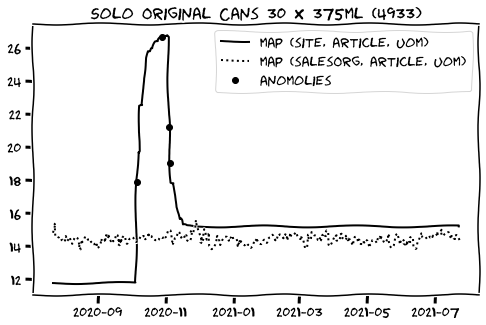

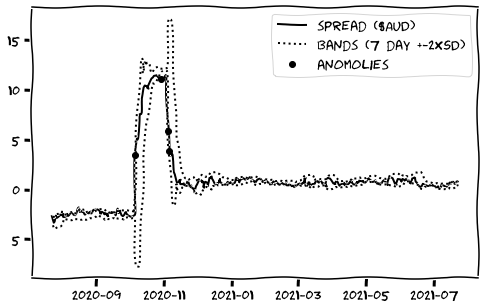

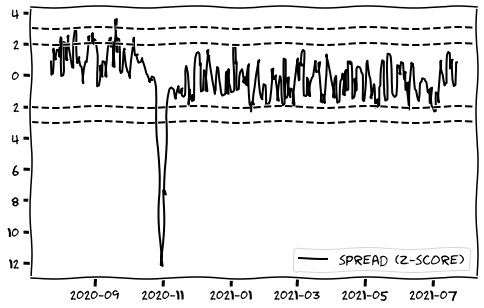

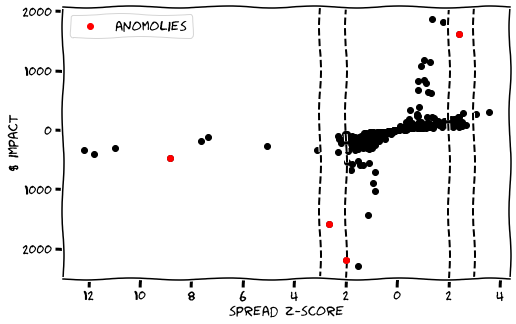

In [98]:
gridPlot_(df,max(df['stock_at_map'].mean()*0.05,1))


We can see from above that approach correctly detects first instance of divergent MAP. Does not duplicate detection.

In [74]:
# #fig_ = gridPlot_(df,max(df['stock_at_map'].mean()*0.05,1))


# def update_figure(fig_):
#   import io
#   import base64
#   #create some matplotlib graph
#   buf = io.BytesIO() # in-memory files
#   fig_
#   plt.close()
#   data = base64.b64encode(buf.getbuffer()).decode("utf8") # encode to html elements
#   return "data:image/png;base64,{}".format(data)

# fig_ = gridPlot_(df,max(df['stock_at_map'].mean()*0.05,1))
# update_figure( fig_ )


## Cigs example
Cigs get big price increase once a year - hence why it's a good example to test. Where univariate model detected a sudden move in the articles price and flag suspicious movement... this model, compares with salesorg price movement per article. Although this may detect an anomoly, it may not. But if so this approach uses a more realistic estimate of dollar impact.

In [75]:
dfCig = get_bq_data("""
select *,
(case when abs(map_spread_z) >=2 then true else false end) as flag_map_spread_z_outsideBounds
from `gcp-wow-finance-de-lab-dev.017_map.01_mapData`
where site = '1004' and
ltrim(article, '0')='135962'
order by soh_date
""", project_id=project)

dfCig['map_dollar_impact'] = pd.to_numeric(dfCig['map_dollar_impact'])
dfCig['map_spread'] =  pd.to_numeric(dfCig.map_spread)

Downloading: 100%|██████████| 365/365 [00:02<00:00, 133.27rows/s]


In [76]:
dfCig.head()

,soh_date,soh_date_lag1d,salesorg_id,site,article,ArticleDescription,article_uom,stock_at_map,stock_on_hand,map,Sales_ExclTax,Sales_Qty_SUoM,ASP,stock_at_map_art_SalesOrg,stock_on_hand_art_SalesOrg,map_art_SalesOrg,Sales_ExclTax_art_SalesOrg,Sales_Qty_SUoM_art_SalesOrg,ASP_art_SalesOrg,stock_at_map_art_SalesOrg_exclRec,stock_on_hand_art_SalesOrg_exclRec,map_art_SalesOrg_exclRec,Sales_ExclTax_art_SalesOrg_exclRec,Sales_Qty_SUoM_art_SalesOrg_exclRec,ASP_art_SalesOrg_exclRec,map_spread,map_spread_ma,map_spread_std,map_spread_lower,map_spread_upper,map_spread_z,map_dollar_impact,lag_stock_at_map,lag_stock_on_hand,lag_map,lag_Sales_ExclTax,lag_Sales_Qty_SUoM,lag_ASP,lag_stock_at_map_art_SalesOrg,lag_stock_on_hand_art_SalesOrg,lag_map_art_SalesOrg,lag_stock_at_map_art_SalesOrg_exclRec,lag_stock_on_hand_art_SalesOrg_exclRec,lag_map_art_SalesOrg_exclRec,lag_Sales_ExclTax_art_SalesOrg,lag_Sales_Qty_SUoM_art_SalesOrg,lag_ASP_art_SalesOrg,lag_Sales_ExclTax_art_SalesOrg_exclRec,lag_Sales_Qty_SUoM_art_SalesOrg_exclRec,lag_ASP_art_SalesOrg_exclRec,lag_map_spread,lag_map_spread_ma,lag_map_spread_std,lag_map_spread_lower,lag_map_spread_upper,lag_map_spread_z,lag_map_dollar_impact,map_diff,stock_at_map_diff,ASP_diff,map_perc_diff,ASP_perc_diff,map_art_SalesOrg_diff,map_art_SalesOrg_perc_diff,asp_art_SalesOrg_diff,asp_art_SalesOrg_perc_diff,detected_by_existing_method,detected_record_v_salesOrg_map_method,flag_map_spread_z_outsideBounds
0,2020-07-23,2020-07-22,1005,1004,135962,Holiday Kings Blue 20pk,EA,803.680000000,39.000000000,20.607179487,360.0,16.0,22.5,1309921.180000000,63522.000000000,20.621535531,335185.77,14994.0,22.354660,1309117.500000000,63483.000000000,20.621544350,334825.77,14978.0,22.354505,-0.014356,-0.014364863,NaN,NaN,NaN,NaN,0.000344,None,None,None,NaN,NaN,NaN,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,None,None,None,NaN,None,NaN,None,None,NaN,NaN,False,False,False
1,2020-07-24,2020-07-23,1005,1004,135962,Holiday Kings Blue 20pk,EA,494.530000000,24.000000000,20.605416667,337.5,15.0,22.5,1372581.460000000,66550.000000000,20.624815327,339795.20,15204.0,22.349066,1372086.930000000,66526.000000000,20.624822325,339457.70,15189.0,22.348917,-0.019399,-0.016885261,0.003564,-0.024014,-0.009757,-0.705143,-0.060322,803.680000000,39.000000000,20.607179487,360.0,16.0,22.5,1309921.180000000,63522.000000000,20.621535531,1309117.500000000,63483.000000000,20.621544350,335185.77,14994.0,22.354660,334825.77,14978.0,22.354505,-0.014356044,-0.014364863,NaN,NaN,NaN,NaN,0.000343941,-0.001762820,-309.150000000,0.0,-0.000085544,0.0,0.003279796,0.000159047,-0.005594,-0.000250,False,False,False
2,2020-07-25,2020-07-24,1005,1004,135962,Holiday Kings Blue 20pk,EA,1195.270000000,58.000000000,20.608103448,135.0,6.0,22.5,1382710.280000000,67047.000000000,20.622999985,308318.70,13793.0,22.353273,1381515.010000000,66989.000000000,20.623012883,308183.70,13787.0,22.353210,-0.014897,-0.016226652,0.002767,-0.021760,-0.010694,0.480788,0.077147,494.530000000,24.000000000,20.605416667,337.5,15.0,22.5,1372581.460000000,66550.000000000,20.624815327,1372086.930000000,66526.000000000,20.624822325,339795.20,15204.0,22.349066,339457.70,15189.0,22.348917,-0.019398660,-0.016885261,0.003564,-0.024014,-0.009757,-0.705143,-0.060321576,0.002686781,700.740000000,0.0,0.000130392,0.0,-0.001815342,-0.000088017,0.004207,0.000188,False,False,False
3,2020-07-26,2020-07-25,1005,1004,135962,Holiday Kings Blue 20pk,EA,1030.390000000,50.000000000,20.607800000,180.0,8.0,22.5,1270772.320000000,61629.000000000,20.619713447,290302.48,12988.0,22.351592,1269741.930000000,61579.000000000,20.619723120,290122.48,12980.0,22.351501,-0.011913,-0.015150769,0.003120,-0.021390,-0.008911,1.037701,0.161866,1195.270000000,58.000000000,20.608103448,135.0,6.0,22.5,1382710.280000000,67047.000000000,20.622999985,1381515.010000000,66989.000000000,20.623012883,308318.70,13793.0,22.353273,308183.70,13787.0,22.353210,-0.014896537,-0.016226652,0.002767,-0.021760,-0.010694,0.4807

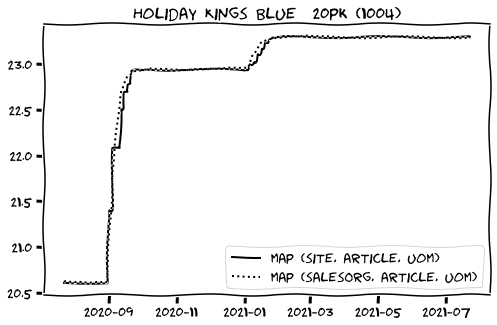

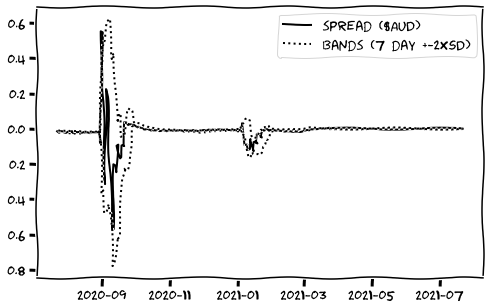

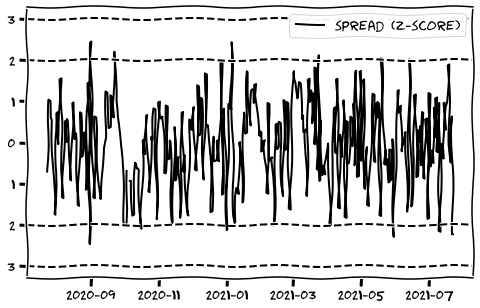

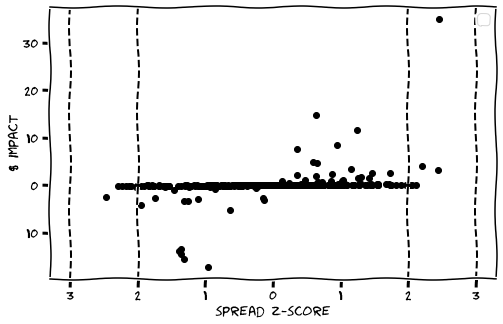

In [99]:
#gridPlot_(dfCig,1)
gridPlot_(dfCig,max(1,dfCig['stock_at_map'].mean()*0.05))

This approach does not flag large map movements when in line with salesorg map movements.

# top down approach
The good news is that per day, site, article, uom data and the above spread + calcs are stored in bigquery.

To show one advantage of this lets take a top-down approach and try to find an article with a big issue on a given day, across many stores.

This can help to pin-point issues that may have material financial impact overall but not at a site level.

In [78]:
# df_highLevel = get_bq_data("""
# SELECT soh_date,	soh_date_lag1d,	salesorg_id,	article,	ArticleDescription,	article_uom,
# sum(stock_on_hand) as sum_stock_on_hand,
# sum(case when abs(spread_z) > 2 then 1 else 0 end) as cnt_anomolies_z_score,
# sum( case when abs(spread_z) > 2 then dollar_impact else 0 end ) as sum_anomoly_dollar_impact,
# (case 
# when sum( case when abs(spread_z) > 2 then stock_on_hand else 0 end ) = 0 then NULL
# when abs(spread_z) > 2 then dollar_impact else 0 end )/sum( case when abs(spread_z) > 2 then stock_on_hand 
# else 0
# end) as sum_anomoly_dollar_impact_per_stock_on_hand
# --sum( case when abs(spread_z) > 2 then dollar_impact else 0 end )/sum( case when abs(spread_z) > 2 then stock_on_hand else 0 end ) as sum_anomoly_dollar_impact_per_stock_on_hand
# FROM `gcp-wow-finance-de-lab-dev.017_map.01_mapData`
# where stock_on_hand != 0
# group by 1,2,3,4,5,6
# having abs(sum_anomoly_dollar_impact)>10000
# order by cnt_anomolies_z_score desc
# limit 1000
# """, project_id=project)

df_highLevel = get_bq_data("""
with dat as (
SELECT soh_date,	soh_date_lag1d,	salesorg_id,	article,	ArticleDescription,	article_uom,
sum(stock_on_hand) as sum_stock_on_hand,
sum(case when abs(map_spread_z) > 2 then 1 else 0 end) as cnt_anomolies_z_score,
sum( case when abs(map_spread_z) > 2 then map_dollar_impact else 0 end ) as sum_anomoly_dollar_impact,
sum( case when abs(map_spread_z) > 2 then stock_on_hand else 0 end ) as sum_anomoly_stock_on_hand
--sum( case when abs(map_spread_z) > 2 then map_dollar_impact else 0 end )/sum( case when abs(map_spread_z) > 2 then stock_on_hand else 0 end ) as sum_anomoly_dollar_impact_per_stock_on_hand
FROM `gcp-wow-finance-de-lab-dev.017_map.01_mapData`
--where stock_on_hand != 0
group by 1,2,3,4,5,6
having abs(sum_anomoly_dollar_impact)>10000
)
select *,
(case when sum_anomoly_stock_on_hand != 0 then sum_anomoly_dollar_impact/sum_anomoly_stock_on_hand else NULL end ) as sum_anomoly_dollar_impact_per_stock_on_hand
from dat
order by cnt_anomolies_z_score desc
limit 1000
""", project_id=project)


Downloading: 100%|██████████| 1000/1000 [00:03<00:00, 297.80rows/s]


In [79]:
df_highLevel.head()

,soh_date,soh_date_lag1d,salesorg_id,article,ArticleDescription,article_uom,sum_stock_on_hand,cnt_anomolies_z_score,sum_anomoly_dollar_impact,sum_anomoly_stock_on_hand,sum_anomoly_dollar_impact_per_stock_on_hand
0,2021-04-24,2021-04-23,1005,675287,Bag For Good,EA,1043012.000000000,989,-19907.234253699,1026855.000000000,-0.019386607
1,2020-12-01,2020-11-30,1005,84552,Coca Cola Cans 30x375ml,EA,97596.000000000,986,-14564.449669866,97212.000000000,-0.149821521
2,2021-03-29,2021-03-28,1005,42605,Coca Cola Drink Cans 24x375ml,EA,109710.000000000,986,-11927.784749780,108607.000000000,-0.109825193
3,2021-04-13,2021-04-12,1005,84552,Coca Cola Cans 30x375ml,EA,45469.000000000,984,12701.349553186,44945.000000000,0.282597609
4,2020-12-14,2020-12-13,1005,84552,Coca Cola Cans 30x375ml,EA,90816.000000000,983,-24579.328580772,89861.000000000,-0.273526097


In [80]:
df_highLevel.query("(cnt_anomolies_z_score>200) & (sum_anomoly_dollar_impact_per_stock_on_hand>1)").sort_values('sum_anomoly_dollar_impact').head()

,soh_date,soh_date_lag1d,salesorg_id,article,ArticleDescription,article_uom,sum_stock_on_hand,cnt_anomolies_z_score,sum_anomoly_dollar_impact,sum_anomoly_stock_on_hand,sum_anomoly_dollar_impact_per_stock_on_hand
127,2020-08-25,2020-08-24,1005,288991,Seafood Salad Mix 1kg,EA,2.368000000,211,-62988.213228873,-179.571000000,350.770521013
129,2020-08-24,2020-08-23,1005,288991,Seafood Salad Mix 1kg,EA,3.637000000,210,-50450.359265508,-211.034000000,239.062706794
90,2021-01-07,2021-01-06,1005,793197,WW Coleslaw 400g,EA,41.000000000,407,-30083.069718630,-2185.000000000,13.767995295
107,2021-06-23,2021-06-22,1005,793197,WW Coleslaw 400g,EA,15.000000000,324,-12919.151968328,-745.000000000,17.341143582
110,2020-08-14,2020-08-13,1005,89823,Sesame Seeds 15kg,,30773.495000000,297,10529.216903307,10232.106000000,1.029037121


look at Blackmores Glucsmn 1500mg Tab 180pk	(828191).
Find a site with a lot of stock that probelematic day with significant divergence in spread.

In [81]:

blackmoresSOHsummary = get_bq_data("""
select Site,
sum(stock_on_hand) as sum_stock_on_hand,
avg(map_spread_z) as map_spread_z,
sum(map_dollar_impact) as map_dollar_impact
from `gcp-wow-finance-de-lab-dev.017_map.01_mapData`
where soh_date = '2020-09-14' and
ltrim(article, '0')='828191' and
salesorg_id = '1005' and
abs(map_spread_z) > 2
group by 1
order by sum_stock_on_hand desc
""", project_id=project)


Downloading: 100%|██████████| 910/910 [00:02<00:00, 404.40rows/s]


In [82]:
blackmoresSOHsummary.head()

,Site,sum_stock_on_hand,map_spread_z,map_dollar_impact
0,3091,52.000000000,2.033155,198.611764104
1,5003,46.000000000,2.001206,175.177060022
2,3055,46.000000000,2.001303,175.163032276
3,3208,46.000000000,2.001287,175.164169672
4,3494,45.000000000,2.011015,171.478017450


In [83]:
blackmoresSOHsummary.tail()

,Site,sum_stock_on_hand,map_spread_z,map_dollar_impact
905,1137,1.000000000,2.258126,3.838299845
906,2692,1.000000000,2.463658,3.940200334
907,2135,1.000000000,2.463757,3.918442857
908,2048,1.000000000,2.464502,3.917236153
909,4385,1.000000000,2.464562,3.916768821


In [84]:
dfBigProblem = get_bq_data("""
select *,
(case when abs(map_spread_z) >=2 then true else false end) as flag_map_spread_z_outsideBounds
from `gcp-wow-finance-de-lab-dev.017_map.01_mapData`
where site = '3969' and
ltrim(article, '0')='828191'
order by soh_date
""", project_id=project)

dfBigProblem['map_dollar_impact'] = pd.to_numeric(dfBigProblem['map_dollar_impact'])
dfBigProblem['map_spread'] =  pd.to_numeric(dfBigProblem.map_spread)

Downloading: 100%|██████████| 365/365 [00:02<00:00, 132.49rows/s]


In [85]:
dfBigProblem.head()

,soh_date,soh_date_lag1d,salesorg_id,site,article,ArticleDescription,article_uom,stock_at_map,stock_on_hand,map,Sales_ExclTax,Sales_Qty_SUoM,ASP,stock_at_map_art_SalesOrg,stock_on_hand_art_SalesOrg,map_art_SalesOrg,Sales_ExclTax_art_SalesOrg,Sales_Qty_SUoM_art_SalesOrg,ASP_art_SalesOrg,stock_at_map_art_SalesOrg_exclRec,stock_on_hand_art_SalesOrg_exclRec,map_art_SalesOrg_exclRec,Sales_ExclTax_art_SalesOrg_exclRec,Sales_Qty_SUoM_art_SalesOrg_exclRec,ASP_art_SalesOrg_exclRec,map_spread,map_spread_ma,map_spread_std,map_spread_lower,map_spread_upper,map_spread_z,map_dollar_impact,lag_stock_at_map,lag_stock_on_hand,lag_map,lag_Sales_ExclTax,lag_Sales_Qty_SUoM,lag_ASP,lag_stock_at_map_art_SalesOrg,lag_stock_on_hand_art_SalesOrg,lag_map_art_SalesOrg,lag_stock_at_map_art_SalesOrg_exclRec,lag_stock_on_hand_art_SalesOrg_exclRec,lag_map_art_SalesOrg_exclRec,lag_Sales_ExclTax_art_SalesOrg,lag_Sales_Qty_SUoM_art_SalesOrg,lag_ASP_art_SalesOrg,lag_Sales_ExclTax_art_SalesOrg_exclRec,lag_Sales_Qty_SUoM_art_SalesOrg_exclRec,lag_ASP_art_SalesOrg_exclRec,lag_map_spread,lag_map_spread_ma,lag_map_spread_std,lag_map_spread_lower,lag_map_spread_upper,lag_map_spread_z,lag_map_dollar_impact,map_diff,stock_at_map_diff,ASP_diff,map_perc_diff,ASP_perc_diff,map_art_SalesOrg_diff,map_art_SalesOrg_perc_diff,asp_art_SalesOrg_diff,asp_art_SalesOrg_perc_diff,detected_by_existing_method,detected_record_v_salesOrg_map_method,flag_map_spread_z_outsideBounds
0,2020-07-23,2020-07-22,1005,3969,828191,Blackmores Glucsmn 1500mg Tab 180pk,EA,7819.300000000,276.000000000,28.330797101,0.0,0.0,NaN,277479.830000000,9845.000000000,28.184848146,888.473,27.0,32.906407,269660.530000000,9569.000000000,28.180638520,888.473,27.0,32.906407,0.145949,0.150158581,NaN,NaN,NaN,NaN,-1.161857,None,None,None,NaN,NaN,NaN,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,None,None,None,NaN,None,NaN,None,None,NaN,NaN,False,False,False
1,2020-07-24,2020-07-23,1005,3969,828191,Blackmores Glucsmn 1500mg Tab 180pk,EA,7819.300000000,276.000000000,28.330797101,0.0,0.0,NaN,288502.850000000,10234.000000000,28.190624389,577.392,17.0,33.964235,280683.550000000,9958.000000000,28.186739305,577.392,17.0,33.964235,0.140173,0.147108189,0.004314,0.138480,0.155736,-1.607702,-1.914192,7819.300000000,276.000000000,28.330797101,0.0,0.0,NaN,277479.830000000,9845.000000000,28.184848146,269660.530000000,9569.000000000,28.180638520,888.473,27.0,32.906407,888.473,27.0,32.906407,0.145948955,0.150158581,NaN,NaN,NaN,NaN,-1.161856776,0E-9,0E-9,NaN,0E-9,NaN,0.005776243,0.000204941,1.057828,0.032147,False,False,False
2,2020-07-25,2020-07-24,1005,3969,828191,Blackmores Glucsmn 1500mg Tab 180pk,EA,7819.300000000,276.000000000,28.330797101,0.0,0.0,NaN,302814.990000000,10739.000000000,28.197689729,474.680,12.0,39.556667,294995.690000000,10463.000000000,28.194178534,474.680,12.0,39.556667,0.133107,0.143611648,0.006781,0.130050,0.157174,-1.549069,-2.899180,7819.300000000,276.000000000,28.330797101,0.0,0.0,NaN,288502.850000000,10234.000000000,28.190624389,280683.550000000,9958.000000000,28.186739305,577.392,17.0,33.964235,577.392,17.0,33.964235,0.140172712,0.147108189,0.004314,0.138480,0.155736,-1.607702,-1.914191652,0E-9,0E-9,NaN,0E-9,NaN,0.007065340,0.000250627,5.592431,0.164656,False,False,False
3,2020-07-26,2020-07-25,1005,3969,828191,Blackmores Glucsmn 1500mg Tab 180pk,EA,7819.300000000,276.000000000,28.330797101,0.0,0.0,NaN,317036.920000000,11241.000000000,28.203622454,235.406,5.0,47.081200,309217.620000000,10965.000000000,28.200421341,235.406,5.0,47.081200,0.127175,0.140302676,0.008629,0.123046,0.157560,-1.521462,-3.623336,7819.300000000,276.000000000,28.330797101,0.0,0.0,NaN,302814.990000000,10739.000000000,28.197689729,294995.690000000,10463.000000000,28.194178534,474.680,12.0,39.556667,474.680,12.0,39.556667,0.133107372,0.143611648,0.006781,0.130050,0.157174,-1.549069,-2.899180176,0E-9,0E-9,NaN,0E-9,NaN,0.005932725,0.000210398,7.524533,0.190222,False,False,False
4,2020-07-27,2020-07-26,1005,

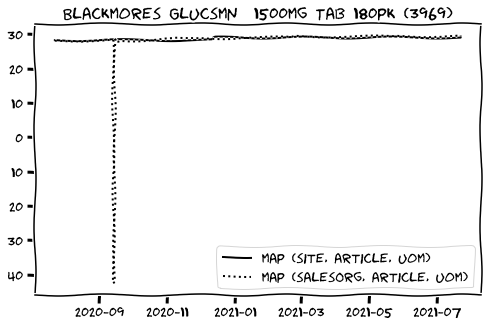

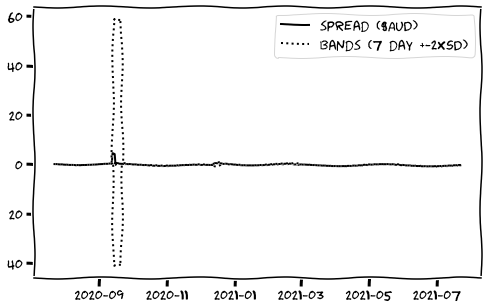

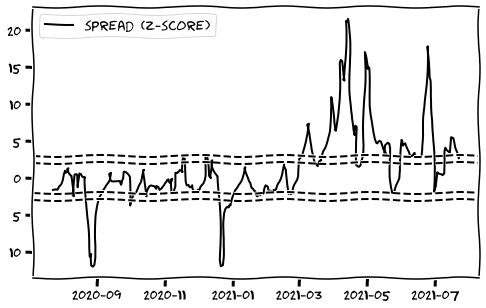

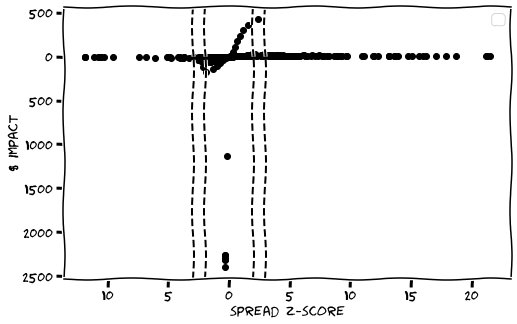

In [100]:
#gridPlot_(dfBigProblem, dollarCutoff=100)
gridPlot_(dfBigProblem, max(1, dfBigProblem['stock_at_map'].mean()*0.05))

This approach flags flat MAP's when pairs spread divergences significatly.

In [87]:
# demonstration of high level summary by article
# lets get a few sites as examples
dfBigProblem_daily = get_bq_data("""
select soh_date, ArticleDescription,
--sum(case when abs(map_spread_z) > 2 then 1 else 0 end) as count_significant_spread_z,

sum(case 
when map_spread_z > 2 then 1
when map_spread_z < -2 then -1
else 0 end) as count_significant_spread_z,

sum(map_dollar_impact) as map_dollar_impact
from `gcp-wow-finance-de-lab-dev.017_map.01_mapData`
where salesorg_id = '1005' and
ltrim(article, '0')='828191'
group by 1,2
order by soh_date
""", project_id=project)

dfBigProblem_daily['map_dollar_impact'] = pd.to_numeric(dfBigProblem_daily['map_dollar_impact'])

Downloading: 100%|██████████| 365/365 [00:02<00:00, 162.65rows/s]


In [88]:
dfBigProblem_daily.head()

,soh_date,ArticleDescription,count_significant_spread_z,map_dollar_impact
0,2020-07-23,Blackmores Glucsmn 1500mg Tab 180pk,0,5.037377
1,2020-07-24,Blackmores Glucsmn 1500mg Tab 180pk,3,-22.039895
2,2020-07-25,Blackmores Glucsmn 1500mg Tab 180pk,0,-61.368037
3,2020-07-26,Blackmores Glucsmn 1500mg Tab 180pk,0,-101.363866
4,2020-07-27,Blackmores Glucsmn 1500mg Tab 180pk,0,-138.460242


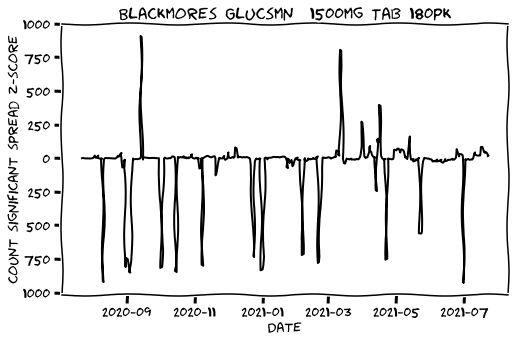

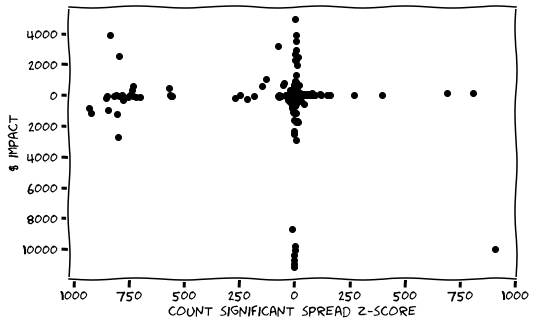

In [89]:
perPlotDim = [8,5]
with plt.xkcd():
    plt.figure(figsize=perPlotDim)
    plt.plot(dfBigProblem_daily.soh_date, dfBigProblem_daily.count_significant_spread_z, '-k', label='map (site, article, uom)')
    plt.xlabel('Date')
    plt.ylabel('count significant spread z-score')
    plt.title(dfBigProblem_daily['ArticleDescription'].iloc[0])


with plt.xkcd():
      plt.figure(figsize=perPlotDim)
      plt.scatter(dfBigProblem_daily.count_significant_spread_z, dfBigProblem_daily.map_dollar_impact, color='k')
      plt.xlabel('count significant spread z-score')
      plt.ylabel('$ impact')



This top-down approach is helpful. It shows us that this article has an ongoing issue not specific to any one site.

# look at a recent example

In [90]:
df_recent_highLvl = get_bq_data("""
SELECT *
FROM `gcp-wow-finance-de-lab-dev.017_map.01_mapData`
where soh_date = '2021-07-08' and
abs(map_spread_z) > 2 and
(case when lag_map =0 then null else map/lag_map end) > 1.1 and
Sales_ExclTax_art_SalesOrg > 0
order by abs(map_dollar_impact) desc
limit 100
""", project_id=project)

Downloading: 100%|██████████| 100/100 [00:02<00:00, 41.72rows/s]


In [91]:
df_recent_highLvl.head()

,soh_date,soh_date_lag1d,salesorg_id,site,article,ArticleDescription,article_uom,stock_at_map,stock_on_hand,map,Sales_ExclTax,Sales_Qty_SUoM,ASP,stock_at_map_art_SalesOrg,stock_on_hand_art_SalesOrg,map_art_SalesOrg,Sales_ExclTax_art_SalesOrg,Sales_Qty_SUoM_art_SalesOrg,ASP_art_SalesOrg,stock_at_map_art_SalesOrg_exclRec,stock_on_hand_art_SalesOrg_exclRec,map_art_SalesOrg_exclRec,Sales_ExclTax_art_SalesOrg_exclRec,Sales_Qty_SUoM_art_SalesOrg_exclRec,ASP_art_SalesOrg_exclRec,map_spread,map_spread_ma,map_spread_std,map_spread_lower,map_spread_upper,map_spread_z,map_dollar_impact,lag_stock_at_map,lag_stock_on_hand,lag_map,lag_Sales_ExclTax,lag_Sales_Qty_SUoM,lag_ASP,lag_stock_at_map_art_SalesOrg,lag_stock_on_hand_art_SalesOrg,lag_map_art_SalesOrg,lag_stock_at_map_art_SalesOrg_exclRec,lag_stock_on_hand_art_SalesOrg_exclRec,lag_map_art_SalesOrg_exclRec,lag_Sales_ExclTax_art_SalesOrg,lag_Sales_Qty_SUoM_art_SalesOrg,lag_ASP_art_SalesOrg,lag_Sales_ExclTax_art_SalesOrg_exclRec,lag_Sales_Qty_SUoM_art_SalesOrg_exclRec,lag_ASP_art_SalesOrg_exclRec,lag_map_spread,lag_map_spread_ma,lag_map_spread_std,lag_map_spread_lower,lag_map_spread_upper,lag_map_spread_z,lag_map_dollar_impact,map_diff,stock_at_map_diff,ASP_diff,map_perc_diff,ASP_perc_diff,map_art_SalesOrg_diff,map_art_SalesOrg_perc_diff,asp_art_SalesOrg_diff,asp_art_SalesOrg_perc_diff,detected_by_existing_method,detected_record_v_salesOrg_map_method
0,2021-07-08,2021-07-07,1005,1111,120080,Avocado Hass,EA,2117.210000000,1232.000000000,1.718514610,474.66,481.0,0.986819,575136.030000000,589453.000000000,0.975711431,359975.49,364360.0,0.987967,573018.820000000,588221.000000000,0.974155666,359500.83,363879.0,0.987968,0.742803179,0.104723628,0.260149,-0.415574,0.625021,2.452748,786.114006832,1107.970000000,1187.000000000,0.933420388,418.99,427.0,0.981241,543861.460000000,555048.000000000,0.979845815,542753.490000000,553861.000000000,0.979945311,342465.68,345029.0,0.992571,342046.69,344602.0,0.992585,-0.046425427,0.015565351,0.030323,-0.045081,0.076212,-2.044330,-73.583053486,0.785094222,1009.240000000,0.005578,0.841093929,0.005685,-0.004134384,-0.004219423,-0.004604,-0.004639,False,False
1,2021-07-08,2021-07-07,1005,1961,120080,Avocado Hass,EA,1461.780000000,770.000000000,1.898415584,251.55,254.0,0.990354,575136.030000000,589453.000000000,0.975711431,359975.49,364360.0,0.987967,573674.250000000,588683.000000000,0.974504530,359723.94,364106.0,0.987965,0.922704153,0.119925173,0.328037,-0.536149,0.776000,2.447219,618.139814600,572.020000000,610.000000000,0.937737705,263.68,266.0,0.991278,543861.460000000,555048.000000000,0.979845815,543289.440000000,554438.000000000,0.979892143,342465.68,345029.0,0.992571,342202.00,344763.0,0.992572,-0.042108110,0.011114624,0.048653,-0.086192,0.108421,-1.093920,-32.465867740,0.960677879,889.760000000,-0.000924,1.024463316,-0.000932,-0.004134384,-0.004219423,-0.004604,-0.004639,False,False
2,2021-07-08,2021-07-07,1005,1174,120080,Avocado Hass,EA,1588.190000000,887.000000000,1.790518602,353.37,357.0,0.989832,575136.030000000,589453.000000000,0.975711431,359975.49,364360.0,0.987967,573547.840000000,588566.000000000,0.974483473,359622.12,364003.0,0.987965,0.814807171,0.122117555,0.283202,-0.444287,0.688522,2.445917,614.415689392,810.370000000,848.000000000,0.955625000,329.68,334.0,0.987066,543861.460000000,555048.000000000,0.979845815,543051.090000000,554200.000000000,0.979882876,342465.68,345029.0,0.992571,342136.00,344695.0,0.992576,-0.024220815,0.058012182,0.106781,-0.155550,0.271575,-0.770108,-69.733581456,0.834893602,777.820000000,0.002766,0.873662370,0.002802,-0.004134384,-0.004219423,-0.004604,-0.004639,False,False
3,2021-07-08,2021-07-07,2010,9508,268824,Wellington Official Prepaid Bags 5pk,EA,13357.900000000,1054.000000000,12.673529412,1378.21,97.0,14.208351,77422.900000000,6438.000000000,12.025924200,6448.97,454.0,14.204780,64065.000000000,5384.000000000,11.899145617,5070.76,357.0,14.203810,0.647605212,0.096875222,0.273755,-0.450634,0.644385,2.011764,580.46

In [92]:
df_recent = get_bq_data("""
select *,
(case when abs(map_spread_z) >=2 then true else false end) as flag_map_spread_z_outsideBounds
from `gcp-wow-finance-de-lab-dev.017_map.01_mapData`
where site = '1174' and
ltrim(article, '0')='120080'
order by soh_date
""", project_id=project)

df_recent['map_dollar_impact'] = pd.to_numeric(df_recent['map_dollar_impact'])
df_recent['map_spread'] =  pd.to_numeric(df_recent.map_spread)


Downloading: 100%|██████████| 365/365 [00:02<00:00, 132.69rows/s]


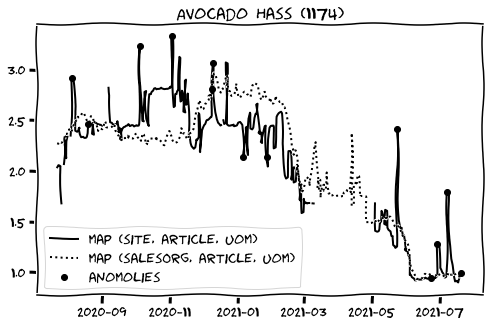

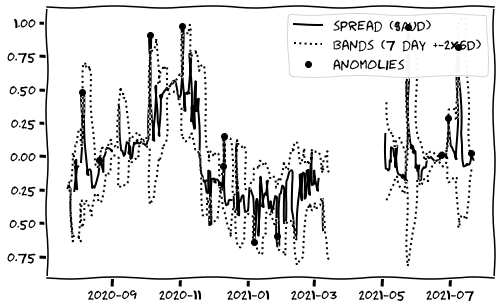

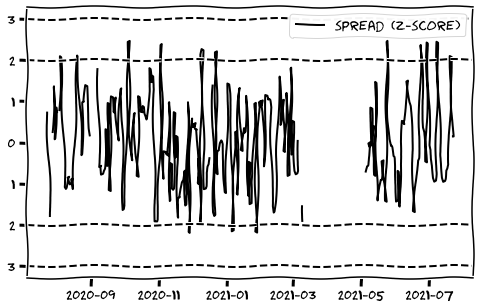

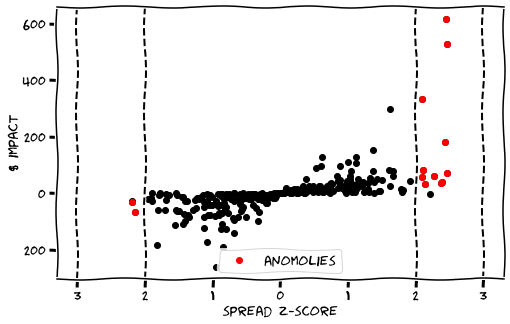

In [101]:
gridPlot_(df_recent, max(1, df_recent['stock_at_map'].mean()*0.05))

Detected under both old and new algo's but this approach gets confirmation by also deviating from salesorg MAP movement.

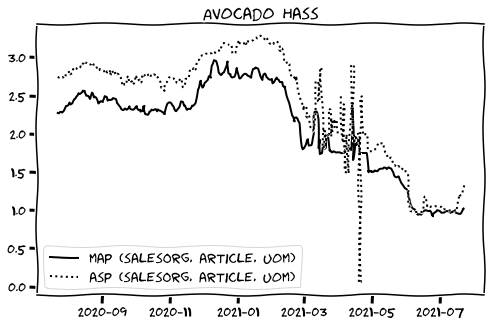

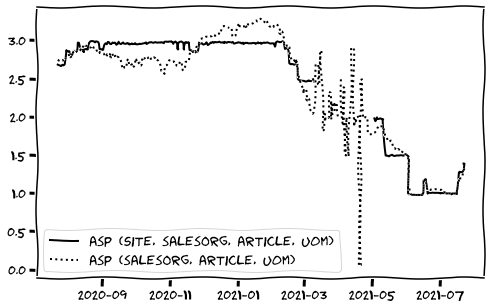

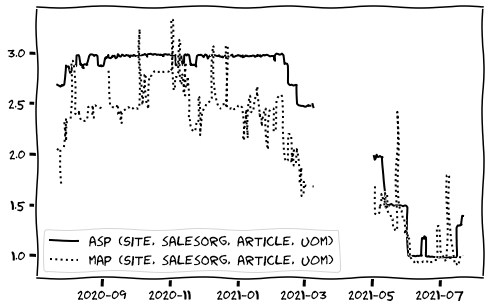

In [102]:
with plt.xkcd():
    plt.figure(figsize=[8,5])
    plt.plot(df_recent.soh_date, df_recent.map_art_SalesOrg, '-k', label='map (salesOrg, article, uom)')
    plt.plot(df_recent.soh_date, df_recent.ASP_art_SalesOrg, ':k', label='asp (salesOrg, article, uom)')
    plt.title(df_recent['ArticleDescription'].iloc[0])
    plt.legend()

with plt.xkcd():
    plt.figure(figsize=[8,5])
    plt.plot(df_recent.soh_date, df_recent.ASP, '-k', label='asp (Site, salesOrg, article, uom)')
    plt.plot(df_recent.soh_date, df_recent.ASP_art_SalesOrg, ':k', label='asp (salesOrg, article, uom)')
    plt.legend()

with plt.xkcd():
    plt.figure(figsize=[8,5])
    plt.plot(df_recent.soh_date, df_recent.ASP, '-k', label='asp (Site, salesOrg, article, uom)')
    plt.plot(df_recent.soh_date, df_recent.map, ':k', label='map (Site, salesOrg, article, uom)')
    plt.legend()



In [95]:
# %%shell
# jupyter nbconvert --to html /content/map_approach.ipynb
